In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array

**Read dataset**

In [2]:
filtered_clothing = pd.read_csv('../../filtered_clothing_dataset.csv')

**Split dataset in training and testing set**

In [3]:
eighty_pct = int(0.8*len(filtered_clothing))
  
train_set = filtered_clothing.iloc[:(eighty_pct-1), :] 
test_set = filtered_clothing.iloc[eighty_pct:, :] 
  
train_set.to_csv("train_data.csv", index=False)
test_set.to_csv("test_data.csv", index=False)

**Loading the dataset**

In [4]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [5]:
# image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data['id'] = train_data['id'].astype(str) + '.jpg'
test_data['id'] = test_data['id'].astype(str) + '.jpg'

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='../../filtered_images',
    x_col="id",
    y_col="articleType",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True) 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='../../filtered_images',
    x_col="id",
    y_col="articleType",
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 22344 validated image filenames belonging to 24 classes.
Found 5587 validated image filenames belonging to 24 classes.


**Loading the MobileNetV2 pretrained model**

In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

**Adding custom classification head on top of MobileNetV2**

In [7]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(24, activation='softmax')  # 24 main subcategories in the dataset
])

**Compiling the model**

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ ?                           │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

**Model training**

In [9]:
# number of training and validation steps
train_steps_per_epoch = len(train_data) // batch_size
test_steps_per_epoch = len(test_data) // batch_size

# model training
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch)

Epoch 1/10


C:\Users\catal\anaconda3\envs\fashion_product_images_small\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


698/698 ━━━━━━━━━━━━━━━━━━━━ 691s 977ms/step - accuracy: 0.6591 - loss: 1.0944 - val_accuracy: 0.7865 - val_loss: 0.5916
Epoch 2/10
  1/698 ━━━━━━━━━━━━━━━━━━━━ 4:59 430ms/step - accuracy: 0.8750 - loss: 0.4016

C:\Users\catal\anaconda3\envs\fashion_product_images_small\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.8750 - loss: 0.2011 - val_accuracy: 0.8421 - val_loss: 0.1490
Epoch 3/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 726s 1s/step - accuracy: 0.8103 - loss: 0.5246 - val_accuracy: 0.7870 - val_loss: 0.6102
Epoch 4/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 488us/step - accuracy: 0.8750 - loss: 0.2140 - val_accuracy: 0.8421 - val_loss: 0.2441
Epoch 5/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 613s 874ms/step - accuracy: 0.8327 - loss: 0.4620 - val_accuracy: 0.8017 - val_loss: 0.5580
Epoch 6/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 0.8125 - loss: 0.2397 - val_accuracy: 0.7368 - val_loss: 0.2219
Epoch 7/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 613s 874ms/step - accuracy: 0.8481 - loss: 0.4128 - val_accuracy: 0.8048 - val_loss: 0.5466
Epoch 8/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 1s 593us/step - accuracy: 0.8125 - loss: 0.2651 - val_accuracy: 0.8421 - val_loss: 0.1891
Epoch 9/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 612s 873ms/step - accuracy: 0.8531 - loss: 0.3969 - val_ac

**Saving the model**

In [10]:
model.save('MobileNetV2_model_20042024_10epochs_article_type.keras')
print("Saving the model as MobileNetV2_model_20042024_10epochs_article_type.keras")

Saving the model as MobileNetV2_model_20042024_10epochs_article_type.keras


**Model evaluation**

In [11]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps_per_epoch)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# predicting the probabilities for the test set
y_pred_proba = model.predict(test_generator)

# converting the probabilities to class predictions
y_pred = np.argmax(y_pred_proba, axis=1)

# getting the true labels
y_true = test_generator.classes

# computing the precision, recall, f1-score, support
print("Classification Report:")
print(classification_report(y_true, y_pred))

# computing the AUC-ROC score with the multi_class='ovr'
auc_roc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
print("AUC-ROC Score (ovr):", auc_roc)

# computing the AUC-ROC score with the multi_class='ovo'
auc_roc_ovo = roc_auc_score(y_true, y_pred_proba, multi_class='ovo')
print("AUC-ROC Score (ovo):", auc_roc_ovo)

174/174 ━━━━━━━━━━━━━━━━━━━━ 77s 441ms/step - accuracy: 0.8016 - loss: 0.5390
Test Loss: 0.5292649865150452
Test Accuracy: 0.8083692789077759
175/175 ━━━━━━━━━━━━━━━━━━━━ 80s 448ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       134
           1       0.64      0.53      0.58        40
           2       0.69      0.86      0.76       550
           3       0.76      0.97      0.85        63
           4       0.72      0.78      0.75        79
           5       0.34      0.18      0.23       102
           6       0.82      0.81      0.81       187
           7       0.77      0.87      0.82       134
           8       0.98      0.83      0.90       342
           9       0.68      0.81      0.74       259
          10       0.64      0.46      0.53        50
          11       0.91      0.59      0.72       124
          12       0.27      0.86      0.41        14
          13       0.91      0.64 

**Accuracy per article type**

175/175 ━━━━━━━━━━━━━━━━━━━━ 86s 489ms/step
Accuracy for subcategory 'Backpacks': 0.9253731343283582
Accuracy for subcategory 'Capris': 0.525
Accuracy for subcategory 'Casual Shoes': 0.8581818181818182
Accuracy for subcategory 'Clutches': 0.9682539682539683
Accuracy for subcategory 'Dresses': 0.7848101265822784
Accuracy for subcategory 'Flats': 0.17647058823529413
Accuracy for subcategory 'Flip Flops': 0.8074866310160428
Accuracy for subcategory 'Formal Shoes': 0.8656716417910447
Accuracy for subcategory 'Handbags': 0.827485380116959
Accuracy for subcategory 'Heels': 0.8108108108108109
Accuracy for subcategory 'Jackets': 0.46
Accuracy for subcategory 'Jeans': 0.5887096774193549
Accuracy for subcategory 'Laptop Bag': 0.8571428571428571
Accuracy for subcategory 'Leggings': 0.6363636363636364
Accuracy for subcategory 'Sandals': 0.7053140096618358
Accuracy for subcategory 'Shirts': 0.953030303030303
Accuracy for subcategory 'Shorts': 0.8691588785046729
Accuracy for subcategory 'Skirts': 0.

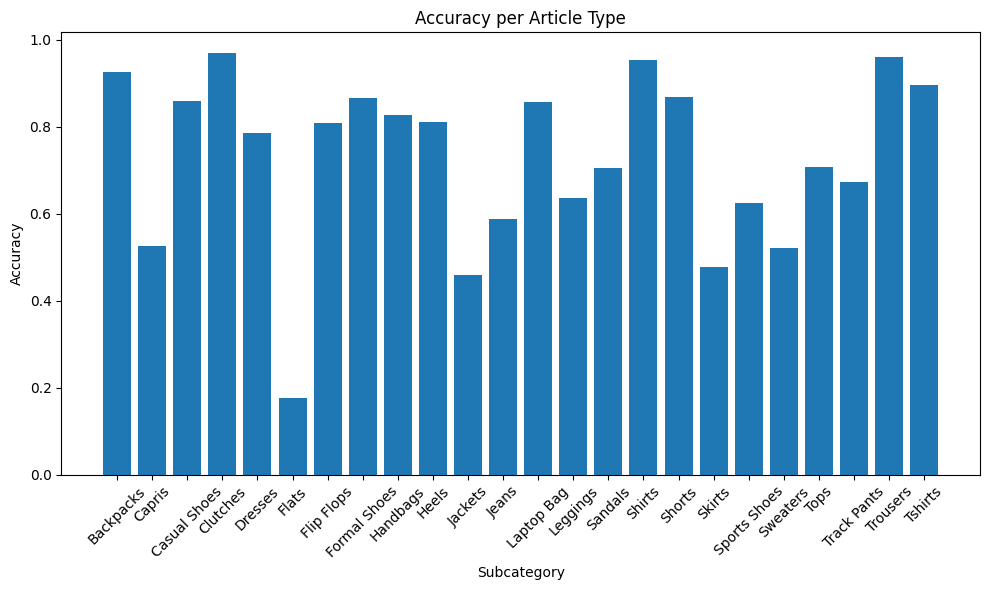

In [14]:
# converting the class_labels to a list
class_labels = list(train_generator.class_indices.keys())

# predicting the probabilities for the test set
predictions = model.predict(test_generator)

# getting the predicted labels for each image
predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]

# getting the true labels for each image
true_labels = [class_labels[i] for i in test_generator.classes]

# initializing a dictionary to store the counts of the correct predictions and the total counts for each subcategory
subcategory_counts = {class_label: [0, 0] for class_label in class_labels}

# iterating through each prediction and updating the counts
for true_label, predicted_label in zip(true_labels, predicted_labels):
    subcategory_counts[true_label][1] += 1
    if true_label == predicted_label:
        subcategory_counts[true_label][0] += 1

# computing the accuracy for each subcategory
subcategory_accuracies = {class_label: (count[0] / count[1]) if count[1] != 0 else 0 for class_label, count in subcategory_counts.items()}

# displaying the accuracy per subcategory
for class_label, accuracy in subcategory_accuracies.items():
    print(f"Accuracy for subcategory '{class_label}': {accuracy}")

# plotting the accuracy per subcategory
plt.figure(figsize=(10, 6)) 
plt.bar(subcategory_accuracies.keys(), subcategory_accuracies.values())
plt.xlabel('Subcategory')
plt.ylabel('Accuracy')
plt.title('Accuracy per Article Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Predict the label and accuracy of an external image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


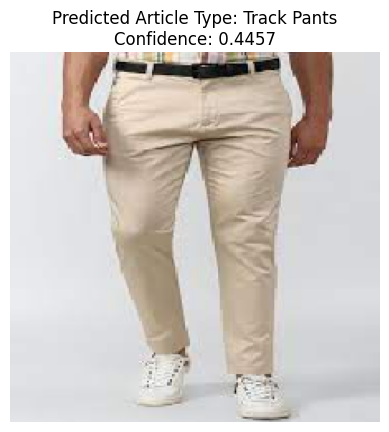

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


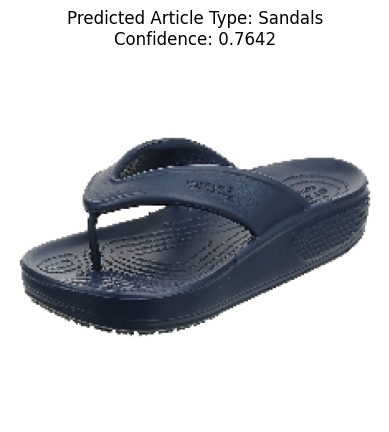

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


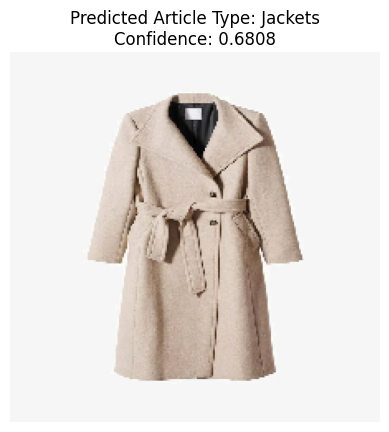

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


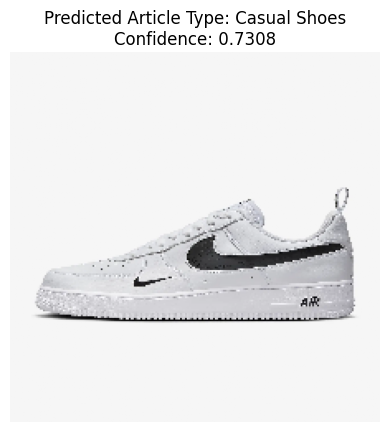

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


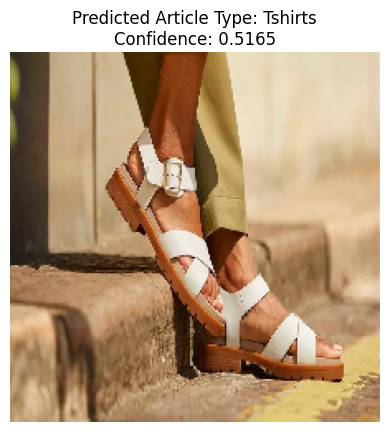

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


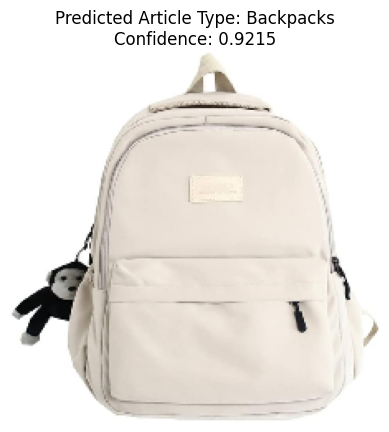

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


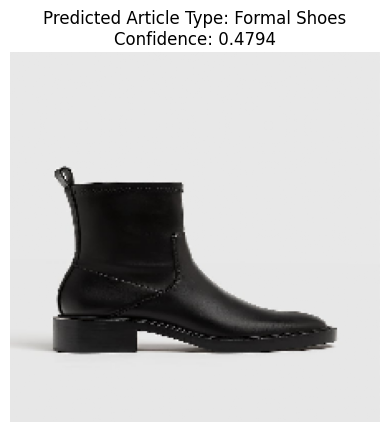

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


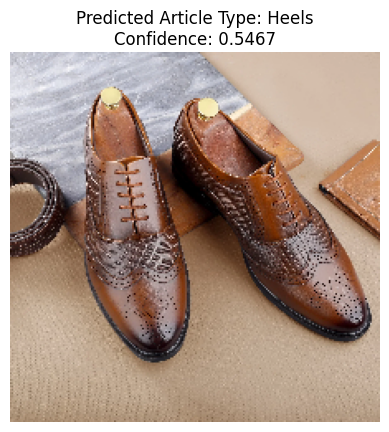

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


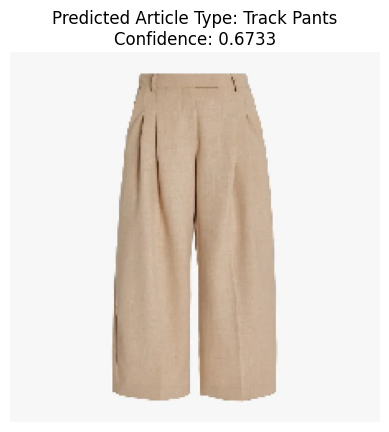

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


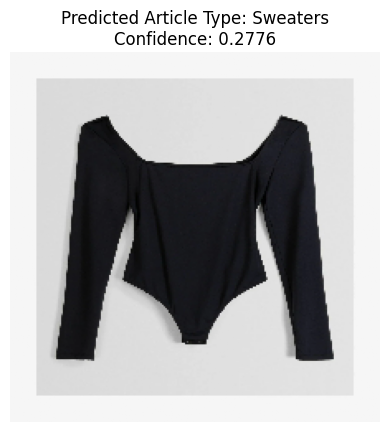

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


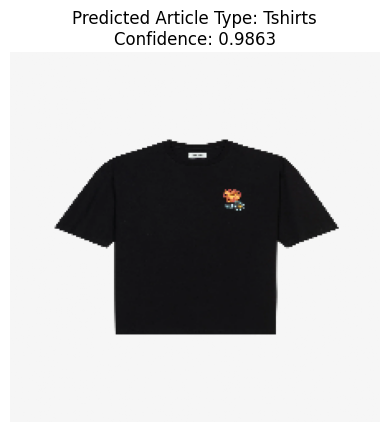

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


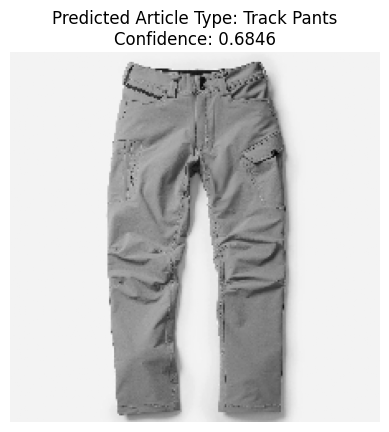

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


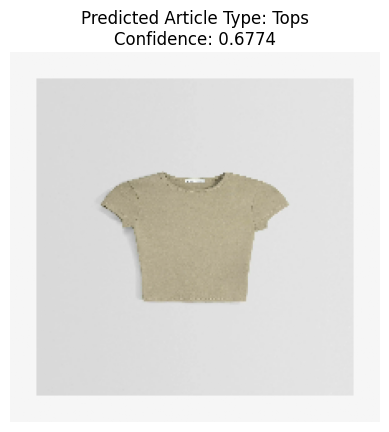

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


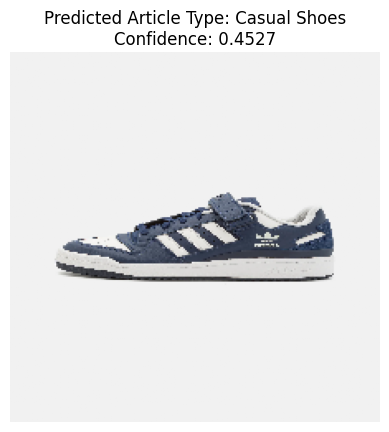

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


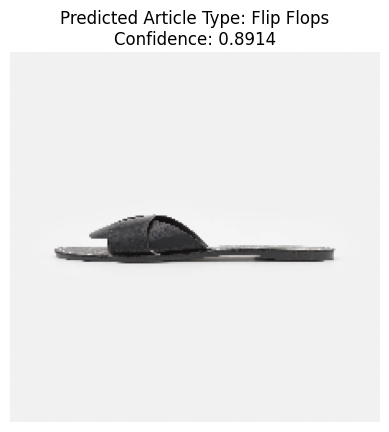

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


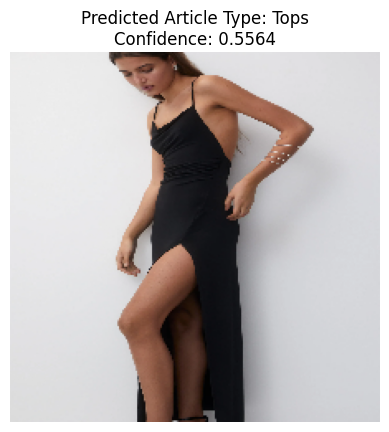

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


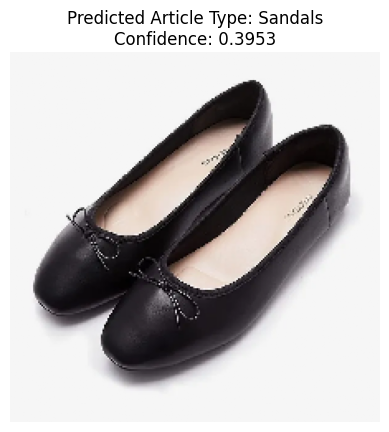

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


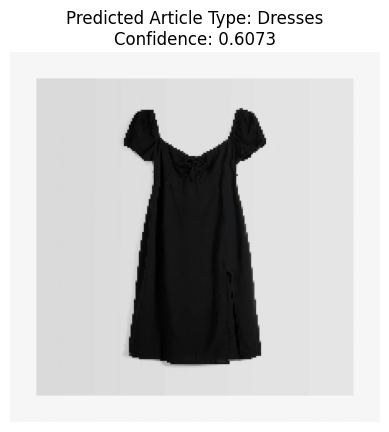

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


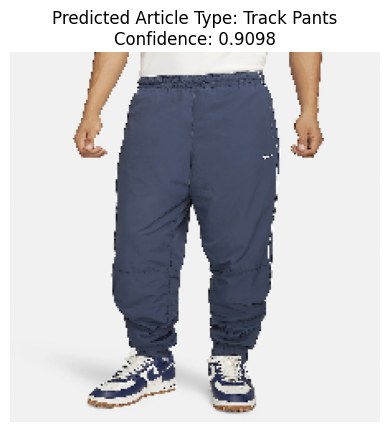

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


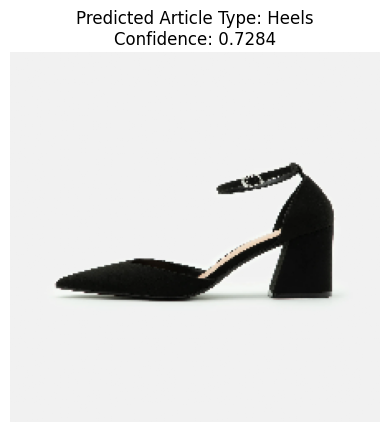

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


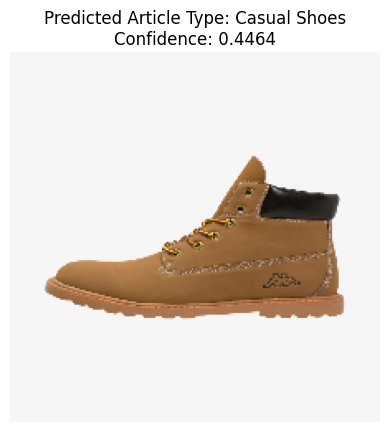

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


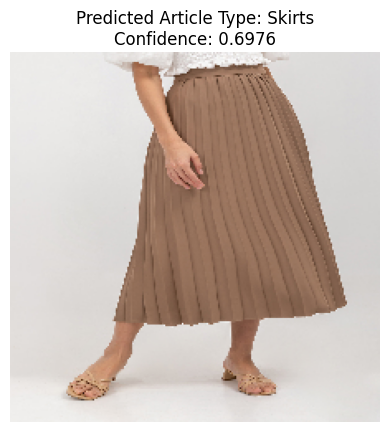

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


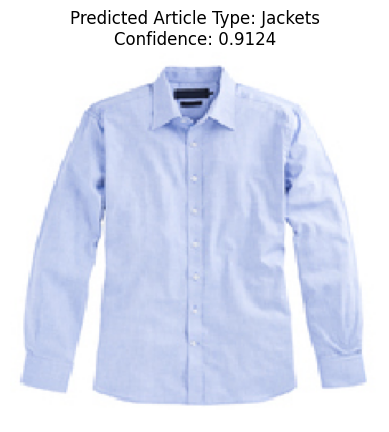

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


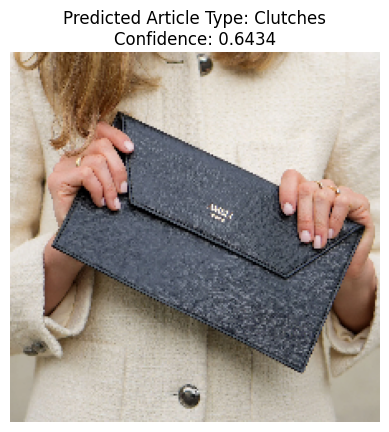

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


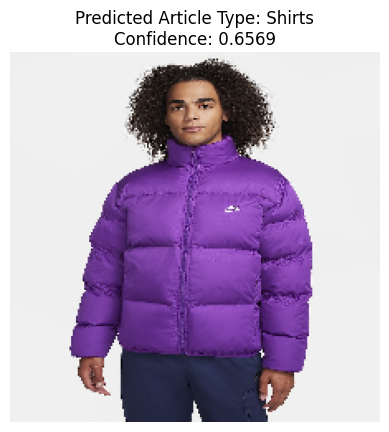

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


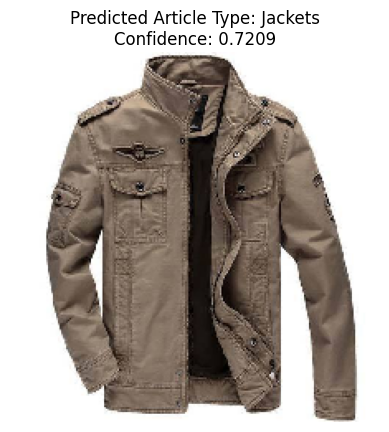

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


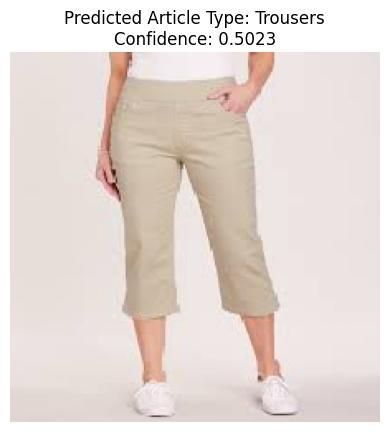

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


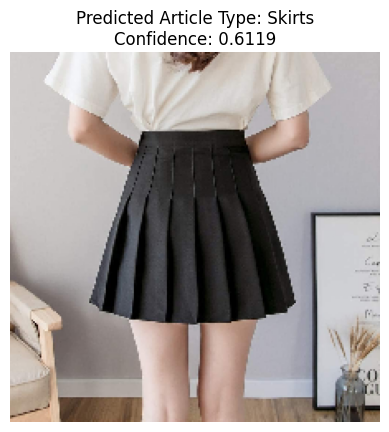

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


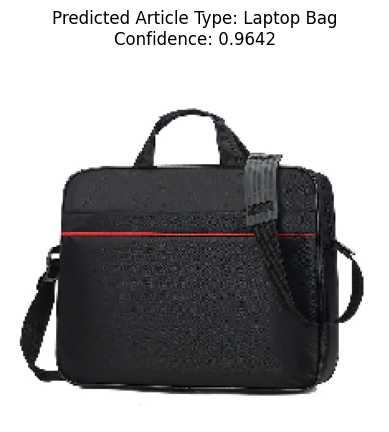

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


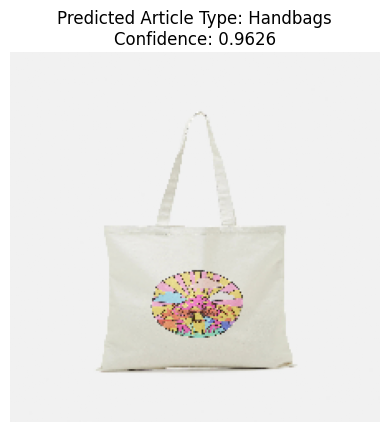

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


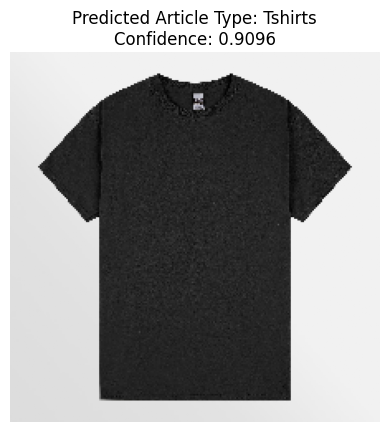

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


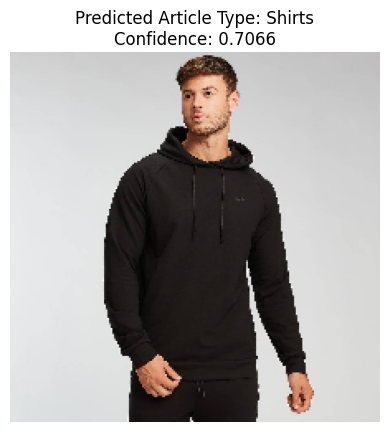

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


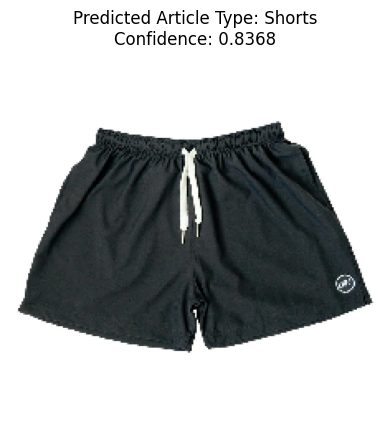

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


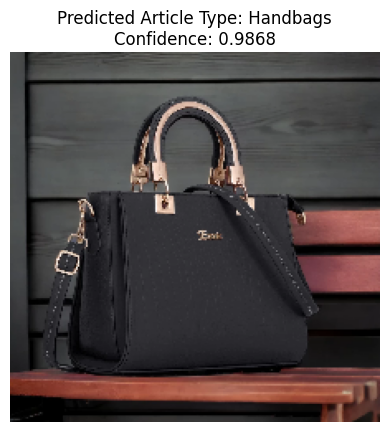

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


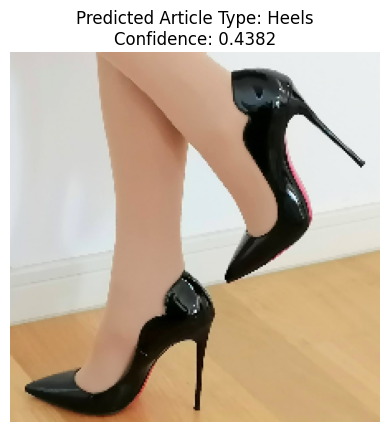

In [15]:
# function to make predictions with dynamically generated category labels
def predict_image_category_with_dynamic_labels(image_path, model, train_generator):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    # getting the index of the class with the highest probability
    predicted_class = np.argmax(predictions[0]) 
    
    # generating a mapping of the class indices to category labels
    class_labels = {i: label for i, label in enumerate(train_generator.class_indices.keys())}

    # getting the corresponding label using the class index
    predicted_label = class_labels[predicted_class] 

    # computing the confidence score of the prediction
    confidence = predictions[0][predicted_class] 
    
    return predicted_label, confidence, img_array

def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 
    return img_array

def parse_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.webp', '.hpg', '.png'))]
    images_data = []
    for file in image_files:
        image_path = os.path.join(folder_path, file)
        preprocessed_image = preprocess_image(image_path)
        images_data.append((image_path, preprocessed_image))
    return images_data


images_folder_path = '../../clothing_test_dataset/'

images_data = parse_images_in_folder(images_folder_path)

for image_path, preprocessed_image in images_data:
    # predicting the category and the confidence for the image
    predicted_label, confidence, img_array = predict_image_category_with_dynamic_labels(image_path, model, train_generator)
    
    # displaying the image along with the predicted category and confidence
    plt.imshow(img_array[0])
    plt.title(f'Predicted Article Type: {predicted_label}\nConfidence: {confidence:.4f}')
    plt.axis('off')
    plt.show()
